# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner
from helpers.splitter import Splitter

# Loading data

In [2]:
time_feature = 'z_timestamp'
df = pd.read_csv('../data/interaction-clean.csv')[['user_id', 'item_id', 'rating_imp', 'timestamp', 'z_timestamp']]
df.head()

,user_id,item_id,rating_imp,timestamp,z_timestamp
0,76561197960432447,10,1,1738278781,0.559647
1,76561198071230926,10,1,1736206418,0.535447
2,76561198206216352,10,1,1738041574,0.556877
3,76561198110801124,10,1,1738015332,0.556570
4,76561199813732773,10,1,1737853720,0.554683


# Indexing data

In [3]:
index_manager = IndexManager()
index_manager.fit(df_interaction=df)
index_manager.transform_interactions(df, inplace=True)
df.head()

Indexed 836887 users and 69001 items
User index range: 0-836886
Item index range: 0-69000


,user_id,item_id,rating_imp,timestamp,z_timestamp
0,0,0,1,1738278781,0.559647
1,1,0,1,1736206418,0.535447
2,2,0,1,1738041574,0.556877
3,3,0,1,1738015332,0.556570
4,4,0,1,1737853720,0.554683


# Splitting data

In [4]:
splitter = Splitter(df)
df_train, df_val, df_test = splitter.leave_k_out_split()

Splitting data with leave-2-out strategy (1 for validation, 1 for testing)
Total users: 836887
Interactions per user: min=1, max=1035, avg=1.4
Note: 706515 users have fewer than 2 interactions.
These users will be placed entirely in the training set.
Split complete: 1156226 total interactions
Train set: 895482 interactions (77.4%)
Validation set: 130372 interactions (11.3%)
Test set: 130372 interactions (11.3%)


# Tuning model

In [5]:
unique_users = index_manager.get_indexed_users()
unique_items = index_manager.get_indexed_items()

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
    time_feature=time_feature,
)

In [6]:
param_grid = {
            'factors': [8, 16, 32, 64],
            'mlp_user_item_dim': [64],
            'mlp_time_dim': [4, 8, 16, 32, 64],
            'learning_rate': [0.0001, 0.0005, 0.001, 0.0015],
            'epochs': [10, 20, 30],
            'optimizer': ['adam', 'adagrad'],
            'dropout': [0.0, 0.2, 0.5],
            'weight_decay': [0.0, 0.0001, 0.0005, 0.00001],
            'loss_fn': ['bce', 'mse', 'bpr'],
            'batch_size': [4096, 8192, 16384],
}

tuner.set_param_grid(param_grid)

In [ ]:
results, file_path = tuner.perform_random_search(num_trials=50)

Running experiment with params: {'factors': 32, 'mlp_user_item_dim': 64, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 10, 'optimizer': 'adam', 'dropout': 0.0, 'weight_decay': 0.0001, 'loss_fn': 'bce', 'batch_size': 4096}
All weights initialized with Gaussian distribution (mean=0, std=0.01)
Epoch 1/10


In [8]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 8, 'mlp_user_item_dim': 512, 'learning_rate': 0.0001, 'epochs': 10, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.0, 'loss_fn': 'mse', 'batch_size': 16384}, 'value': 0.03729197608439011}, 'NDCG@10': {'params': {'factors': 8, 'mlp_user_item_dim': 512, 'learning_rate': 0.0001, 'epochs': 10, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.0, 'loss_fn': 'mse', 'batch_size': 16384}, 'value': 0.018848466851594047}, 'Recall@10': {'params': {'factors': 8, 'mlp_user_item_dim': 512, 'learning_rate': 0.0001, 'epochs': 10, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.0, 'loss_fn': 'mse', 'batch_size': 16384}, 'value': 0.036657828427078966}}


# Analyzing results

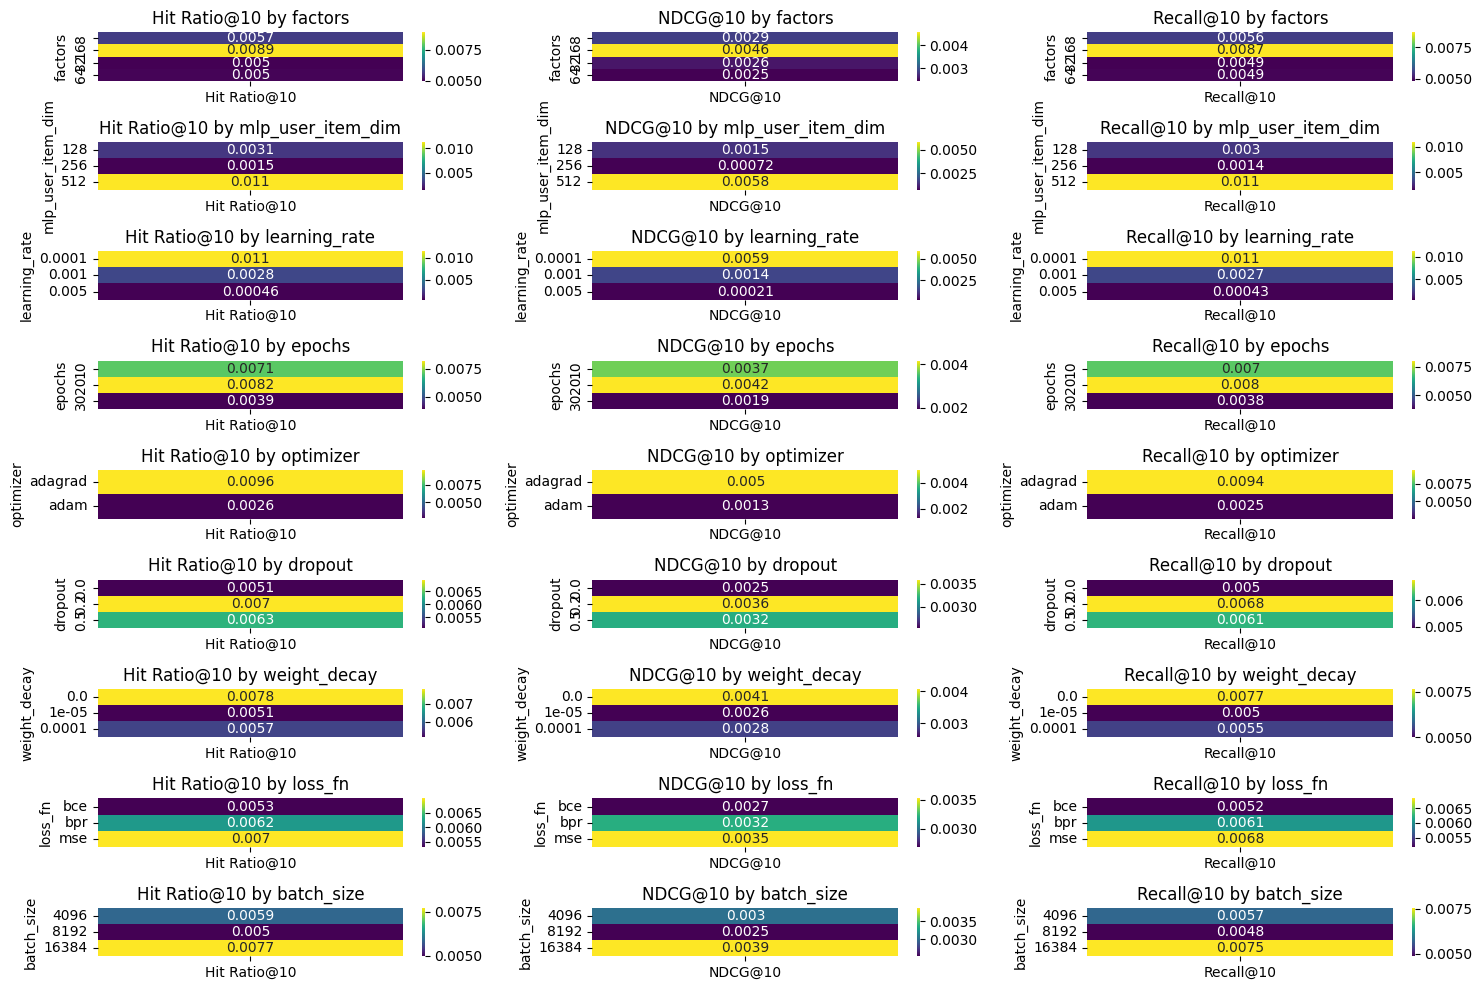

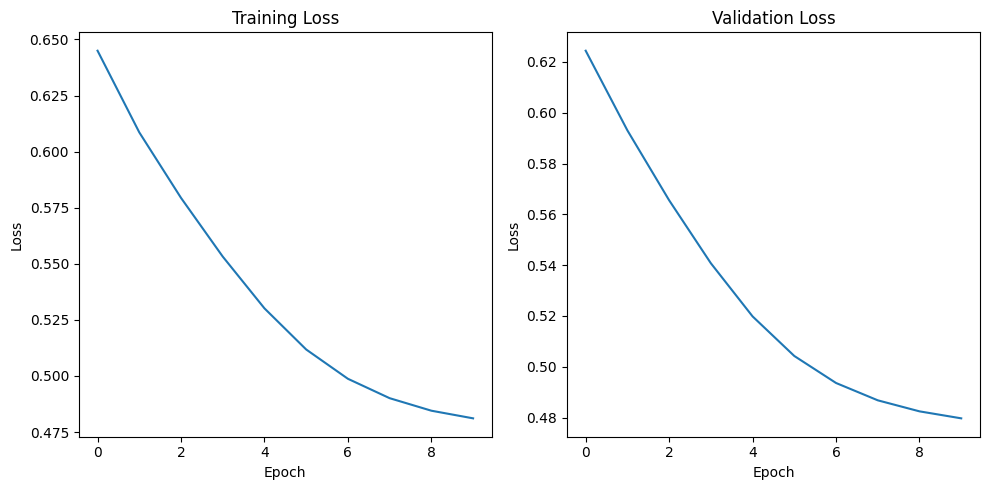

In [9]:
df_result = tuner.plot_results()

In [24]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,Hit Ratio@10,NDCG@10,Recall@10
0,32,256,0.0050,30,adam,0.5,0.00001,bce,8192,0.000257,0.000104,0.000244
1,8,128,0.0001,10,adagrad,0.2,0.00010,bce,8192,0.000181,0.000068,0.000165
2,16,512,0.0050,10,adam,0.2,0.00001,bpr,16384,0.000171,0.000072,0.000159
3,8,256,0.0010,20,adam,0.0,0.00001,bpr,4096,0.000190,0.000078,0.000172
4,8,512,0.0050,30,adagrad,0.2,0.00001,bpr,16384,0.000524,0.000269,0.000495
5,64,128,0.0010,20,adam,0.5,0.00001,bce,4096,0.000190,0.000067,0.000150
6,16,128,0.0010,10,adam,0.5,0.00001,bce,16384,0.000200,0.000070,0.000182
7,32,512,0.0001,10,adagrad,0.2,0.00000,bce,8192,0.015471,0.008875,0.015149
8,8,512,0.0001,10,adagrad,0.5,0.00000,mse,16384,0.037292,0.018848,0.036658
9,32,512,0.0010,20,adagrad,0.5,0.00000,bpr,8192,0.008112,0.004051,0.007822


# Train model with best params

In [11]:
best_param = best_params['Hit Ratio@10']['params']
best_param['mlp_user_item_dim'] = 256

train_dataset = NCFDataset(df_train, time_feature=time_feature)
val_dataset = NCFDataset(df_val, time_feature=time_feature)

dataloader_params = {
    'batch_size': best_param.pop('batch_size'),
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 2,
    'pin_memory': True,
    'shuffle': True
}

train_dataloader = DataLoader(train_dataset, **dataloader_params)
eval_dataloader = DataLoader(val_dataset, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, **best_param)
model.fit(train_dataloader, eval_dataloader)

evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Epoch 1/10
Train loss: 0.255410, Validation loss: 0.247733
Epoch 2/10
Train loss: 0.232500, Validation loss: 0.224495
Epoch 3/10
Train loss: 0.211441, Validation loss: 0.203578
Epoch 4/10
Train loss: 0.194376, Validation loss: 0.186387
Epoch 5/10
Train loss: 0.181795, Validation loss: 0.174441
Epoch 6/10
Train loss: 0.173393, Validation loss: 0.166921
Epoch 7/10
Train loss: 0.168060, Validation loss: 0.161168
Epoch 8/10
Train loss: 0.164419, Validation loss: 0.158653
Epoch 9/10
Train loss: 0.162216, Validation loss: 0.156615
Epoch 10/10
Train loss: 0.160735, Validation loss: 0.154409
Training completed!
Starting evaluation preparation...
Creating ground truth sets...
Ground truth created for 105036 users with an average of 1.1 items each
Ground truth creation completed in 1.86 seconds
Generating predictions for 105036 users...
Processing predictions for 105036 users and 69001 items
Processing user batch 1/206 (512 users)
High memory usage detected! Reduced batch sizes: users=256, items

In [12]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0088255
NDCG@10:	 0.0047692
Recall@10:	 0.0087047


# Interpretting predictions

In [13]:
df_interaction_count = df.groupby('user_id')[['item_id']].nunique().sort_values('item_id', ascending=False)

In [14]:
df_interaction_count[df_interaction_count['item_id'] == 10]

,item_id
user_id,
141666,10
158712,10
50193,10
255627,10
52048,10
...,...
118056,10
356725,10
17134,10


In [15]:
user_id = 141666

In [16]:
df[df['user_id'] == user_id]

,user_id,item_id,rating_imp
158130,141666,33017,0
168364,141666,33789,0
324424,141666,45795,1
384844,141666,50159,0
699841,141666,3261,0
963573,141666,12581,0
986333,141666,13777,1
1012781,141666,15355,1
1028380,141666,16342,0
1110849,141666,21866,1


In [17]:
predictions = model.batch_predict_for_users([user_id])

Processing predictions for 1 users and 69001 items
Processing user batch 1/1 (1 users)
Prediction completed in 0.25 seconds


In [18]:
predictions

{141666: [36404, 4348, 35167, 60708, 12152, 17337, 63327, 761, 41446, 45480]}

## Metadata

In [19]:
df_metadata = pd.read_csv('../data/metadata-clean.csv')
df_metadata.head()

,name,item_id,supported_languages,developers,publishers,categories,genres,total_recommendations,released_date,tags,price
0,Clash of Warlords,1430720,"['Simplified Chinese', 'Traditional Chinese']",['XINLINE GAMES'],['XINLINE GAMES'],"['Single-player', 'In-App Purchases', 'Family ...",['Strategy'],0,2021-02-07,"['Turn-Based Tactics', 'Strategy', 'Wargame', ...",699.0
1,Mine Crazy: The Korean Grinder,1430740,['English'],['Dano Sato'],['RealMono Inc.'],"['Single-player', 'Family Sharing']","['Casual', 'Indie', 'RPG', 'Simulation']",0,2020-10-08,"['Casual', 'RPG', 'Simulation', 'Clicker', 'Fa...",199.0
2,Fade,1430100,['English'],['Azimyth Studios'],['Azimyth Studios'],"['Single-player', 'Family Sharing']","['Indie', 'RPG']",0,2020-10-29,"['Horror', 'RPG', 'Survival Horror', 'Top-Down...",199.0
3,Clash: Artifacts of Chaos,1430680,"['English', 'French', 'Italian', 'German', 'Sp...",['ACE Team'],['Nacon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Adventure', 'Indie']",759,2023-03-09,"['Action', 'Adventure', 'RPG', 'Souls-like', '...",2999.0
4,Astatos,1430970,"['English', 'Simplified Chinese', 'Traditional...",['Studio Klondike Australia'],['Studio Klondike'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Adventure', 'Indie', 'Strategy', 'Early Acce...",243,2021-12-16,"['Early Access', 'Visual Novel', 'Card Battler...",1499.0


## User actual items

In [20]:
user_actual_items = df[(df['user_id'] == user_id) & (df['rating_imp'] == 1)]['item_id'].values
user_actual_items = [index_manager.item_idx_to_id[item] for item in user_actual_items]
user_actual_items

[1796130, 624330, 676730, 886610]

In [21]:
df_metadata[df_metadata['item_id'].isin(user_actual_items)][['name', 'item_id', 'publishers', 'genres', 'tags']]

,name,item_id,publishers,genres,tags
8874,The Mystery of Happyville,886610,['Studio HK'],"['Violent', 'Gore', 'Action', 'Adventure', 'Ca...","['Action', 'Adventure', 'Indie', 'Casual', 'Go..."
17043,Behind The Door,676730,['Dio Alias Games'],"['Adventure', 'Indie']","['Indie', 'Adventure', 'Puzzle', 'Horror', 'Po..."
85275,Scare: Project of Fear,1796130,['HV'],"['Action', 'Adventure', 'Indie', 'Simulation']","['Survival Horror', 'Psychological Horror', 'S..."


## Predicted items

In [22]:
predictions = [index_manager.item_idx_to_id[item] for item in predictions[user_id]]
predictions

[1413300,
 339740,
 1367320,
 2641930,
 573270,
 739630,
 2814760,
 45400,
 1610650,
 1783350]

In [23]:
df_metadata[df_metadata['item_id'].isin(predictions)][['name', 'item_id', 'publishers', 'genres', 'tags']]

,name,item_id,publishers,genres,tags
2112,Close Combat: Cross of Iron,1367320,['Slitherine Ltd.'],"['Simulation', 'Strategy']","['Simulation', 'Strategy', 'RTS', 'Real Time T..."
33071,Immortals Must Die,2814760,['Charles Paiva'],"['Action', 'Adventure', 'Indie']","['Action', 'Action Roguelike', 'Rogue-lite', '..."
40925,SuiCats,339740,"[""Beza's Workshop""]","['Casual', 'Indie']","['Casual', 'Arcade', 'Puzzle', 'Match 3', 'Tim..."
40979,Dezinsector,1413300,['Laush Studio'],"['Casual', 'Indie']","['Casual', 'Adventure', 'Strategy', 'Tower Def..."
43861,Fortix,45400,['Nemesys Games'],['Indie'],"['Indie', 'Casual', 'Arcade', 'Fantasy', 'Sing..."
51169,Ghost Hunters,2641930,['FAILOT GAMES'],"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Adventure', 'Action', 'Action RPG', 'Shooter..."
71434,Alcatraz: VR Escape Room,573270,['OriginsVR'],"['Adventure', 'Indie', 'RPG', 'Simulation']","['Adventure', 'Indie', 'Simulation', 'RPG', 'V..."
81327,●LIVE IN DUNGEON,1610650,['Heaviside Creations'],"['Indie', 'RPG']","['Grid-Based Movement', 'RPG', 'First-Person',..."
82086,Phasmophobia,739630,['Kinetic Games'],"['Action', 'Indie', 'Early Access']","['Horror', 'Online Co-Op', 'Multiplayer', 'Psy..."
85716,A Frustrating Platformer,1783350,['OTB Games'],"['Adventure', 'Casual', 'Indie', 'Strategy']","['2D Platformer', 'Casual', 'Runner', 'Hidden ..."
